<a href="https://colab.research.google.com/github/ptkeens/cs5262-data-science-project/blob/eda/neo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating the Danger of Near Earth Orbit Asteroids

## Background
Asteroids are the rocky remnants of material leftover from the solar system's formation, and are generally found in our solar system's "main belt", located between Mars and Jupitter. <sub>1</sub>. The current known asteroid count is 1,302,459, the vast majority of which orbit in the main asteroid belt. <sub>1</sub>. Asteroids are generally classified into 3 categories: Main Belt, Trojan, and Near-Earth <sub>1</sub>.

## Project Description
This project will focus on Near-Earth Objects (NEO). These objects are defined as "potentially hazardous" when its minimum orbit intersection distance is &lt;0.05 AU (4,647,790 mi) and it has an absolute magnitude of H&lt;22 (i.e. mean diameter > 140 m)<sub>2</sub>. Given that we are evaluating space-bound objects, it is important to remember that many of these values are given in a range format, or are an estimation based on available data sources. The data has been gathered in a kaggle dataset, which was sourced from the NASA NEO Earth Close Approaches API (https://cneos.jpl.nasa.gov/ca/).

## Performance Metrics
In this project, we have a set of 27,423 unique NEO objects with accompanying attribute data such as estimated diameter, relative velocity (to Earth at close approach), the distance by which it misses the Earth, its absolute magnitude, and whether or not it is considered "hazardous".

The goal of this project will be to clean the data to ensure it obeys the defined rules for an object being considered hazardous, and to then use this data as a training set for a machine-learning model to evaluate the boolean condition of if an NEO is considered hazardous. The exact mathematical expressions that will be used will be discovered as we progress through the course.

## Data Sources
This project is using data from a kaggle dataset, found [here](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects)

1 Nasa (2021, July 19). *Asteroids*. https://solarsystem.nasa.gov/asteroids-comets-and-meteors/asteroids/in-depth/

2 Perna, D., Barucci, M.A, Fulchignoni, M (2013). "The near-Earth objects and their potential threat to our planet". *The Astronomy and astrophysics review*, 21(1), 1-28

## Setting Up

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.utils import resample

## Loading The Data

In [56]:
raw = pd.read_csv('neo_v2.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


## Take a look at a random sampling of data

In [58]:
raw.sample(10)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
5631,2163081,163081 (2002 AG29),0.515887,1.153559,29518.598088,5.110802e+07,Earth,False,18.560,False
15867,3368294,(2007 DA),0.088015,0.196807,49113.949336,2.302301e+07,Earth,False,22.400,False
26657,3689357,(2014 SJ143),0.110804,0.247765,34731.066057,3.948824e+07,Earth,False,21.900,False
7673,3170233,(2004 AD),0.035039,0.078350,18262.659927,4.283342e+07,Earth,False,24.400,False
57495,2137170,137170 (1999 HF1),3.195619,7.145621,89327.475201,4.616111e+07,Earth,False,14.600,False
63497,3766665,(2017 AT20),0.010036,0.022441,27170.318017,2.020552e+06,Earth,False,27.115,False
34879,3836258,(2018 WB),0.063761,0.142574,51103.111333,6.446554e+06,Earth,False,23.100,False
53241,3742056,(2016 CD31),0.011080,0.024777,65573.948249,6.643280e+07,Earth,False,26.900,False
12096,2068950,68950 (2002 QF15),1.420872,3.177167,51357.195438,6.020851e+07,Earth,False,16.360,True
89089,3772395,(2017 FT64),0.035039,0.078350,48267.089341,4.203144e+07,Earth,False,24.400,False


## Examine how many duplicates records we have

This dataset contains information about many passes, the original data source says we should have 27,423 unique NEOs

In [4]:
raw.groupby('id').count()

,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
id,,,,,,,,,
2000433,3,3,3,3,3,3,3,3,3
2000719,1,1,1,1,1,1,1,1,1
2001036,1,1,1,1,1,1,1,1,1
2001566,5,5,5,5,5,5,5,5,5
2001580,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...
54275849,1,1,1,1,1,1,1,1,1
54275852,1,1,1,1,1,1,1,1,1
54275853,1,1,1,1,1,1,1,1,1


## Prune some data we don't want for our model

We don't need/want the `id`, `name`, `orbiting_body` or `sentry_object` columns

In [5]:
refined = raw.drop(['id', 'name', 'orbiting_body', 'sentry_object'], axis=1)
refined


,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True
...,...,...,...,...,...,...
90831,0.026580,0.059435,52078.886692,1.230039e+07,25.00,False
90832,0.016771,0.037501,46114.605073,5.432121e+07,26.00,False
90833,0.031956,0.071456,7566.807732,2.840077e+07,24.60,False
90834,0.007321,0.016370,69199.154484,6.869206e+07,27.80,False


## Looking for empty values

In [6]:
refined.isna().sum()

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

## Distribution of hazardous value
I suspect that our data set is imbalanced, what is the ratio of hazardous to non-hazardous?

([<matplotlib.patches.Wedge at 0x7f09b7848dc0>,
 [Text(-1.0489888280748159, 0.33109279450665313, 'False'),
  Text(1.0489888435743868, -0.3310927453999418, 'True')])

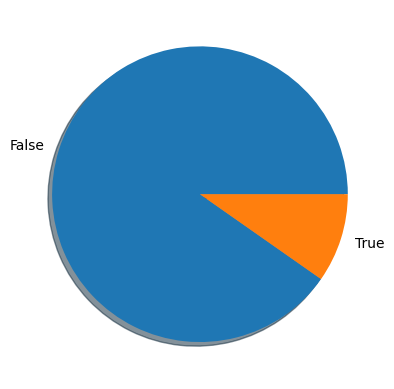

In [8]:
hazardous_values = refined['hazardous'].value_counts()
plt.pie(hazardous_values, labels=hazardous_values.index, shadow = True)

## Examine our raw counts for each class

In [51]:
print(hazardous_values)

# assign the count to a variable for use below
maximum_class_size = hazardous_values[True]

False    81996
True      8840
Name: hazardous, dtype: int64


## Restoring the balance
So we have a heavy imbalance towards non-hazardous NEOs, but this may have an adverse impact on the ML model. We can resample our data into the majority and minority class and create a new data frame that is balanced

In [55]:
# define our majority and minority class by selecting hazardous into one frame, and non-hazardous into another
df_majority = refined[refined['hazardous'] == 0]
df_minority = refined[refined['hazardous'] == 1]

# Resample the classes with the size of the minority class as the max
majority_class = resample(df_majority, replace=True, n_samples=maximum_class_size, random_state=0)
minority_class = resample(df_minority, replace=True, n_samples=maximum_class_size, random_state=0)

# Combine them into a new data frame
new = pd.concat([majority_class, minority_class])

# Examine the split of our new data frame
new['hazardous'].value_counts()



False    8840
True     8840
Name: hazardous, dtype: int64

## Examine the distribution of data for our new data frame

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


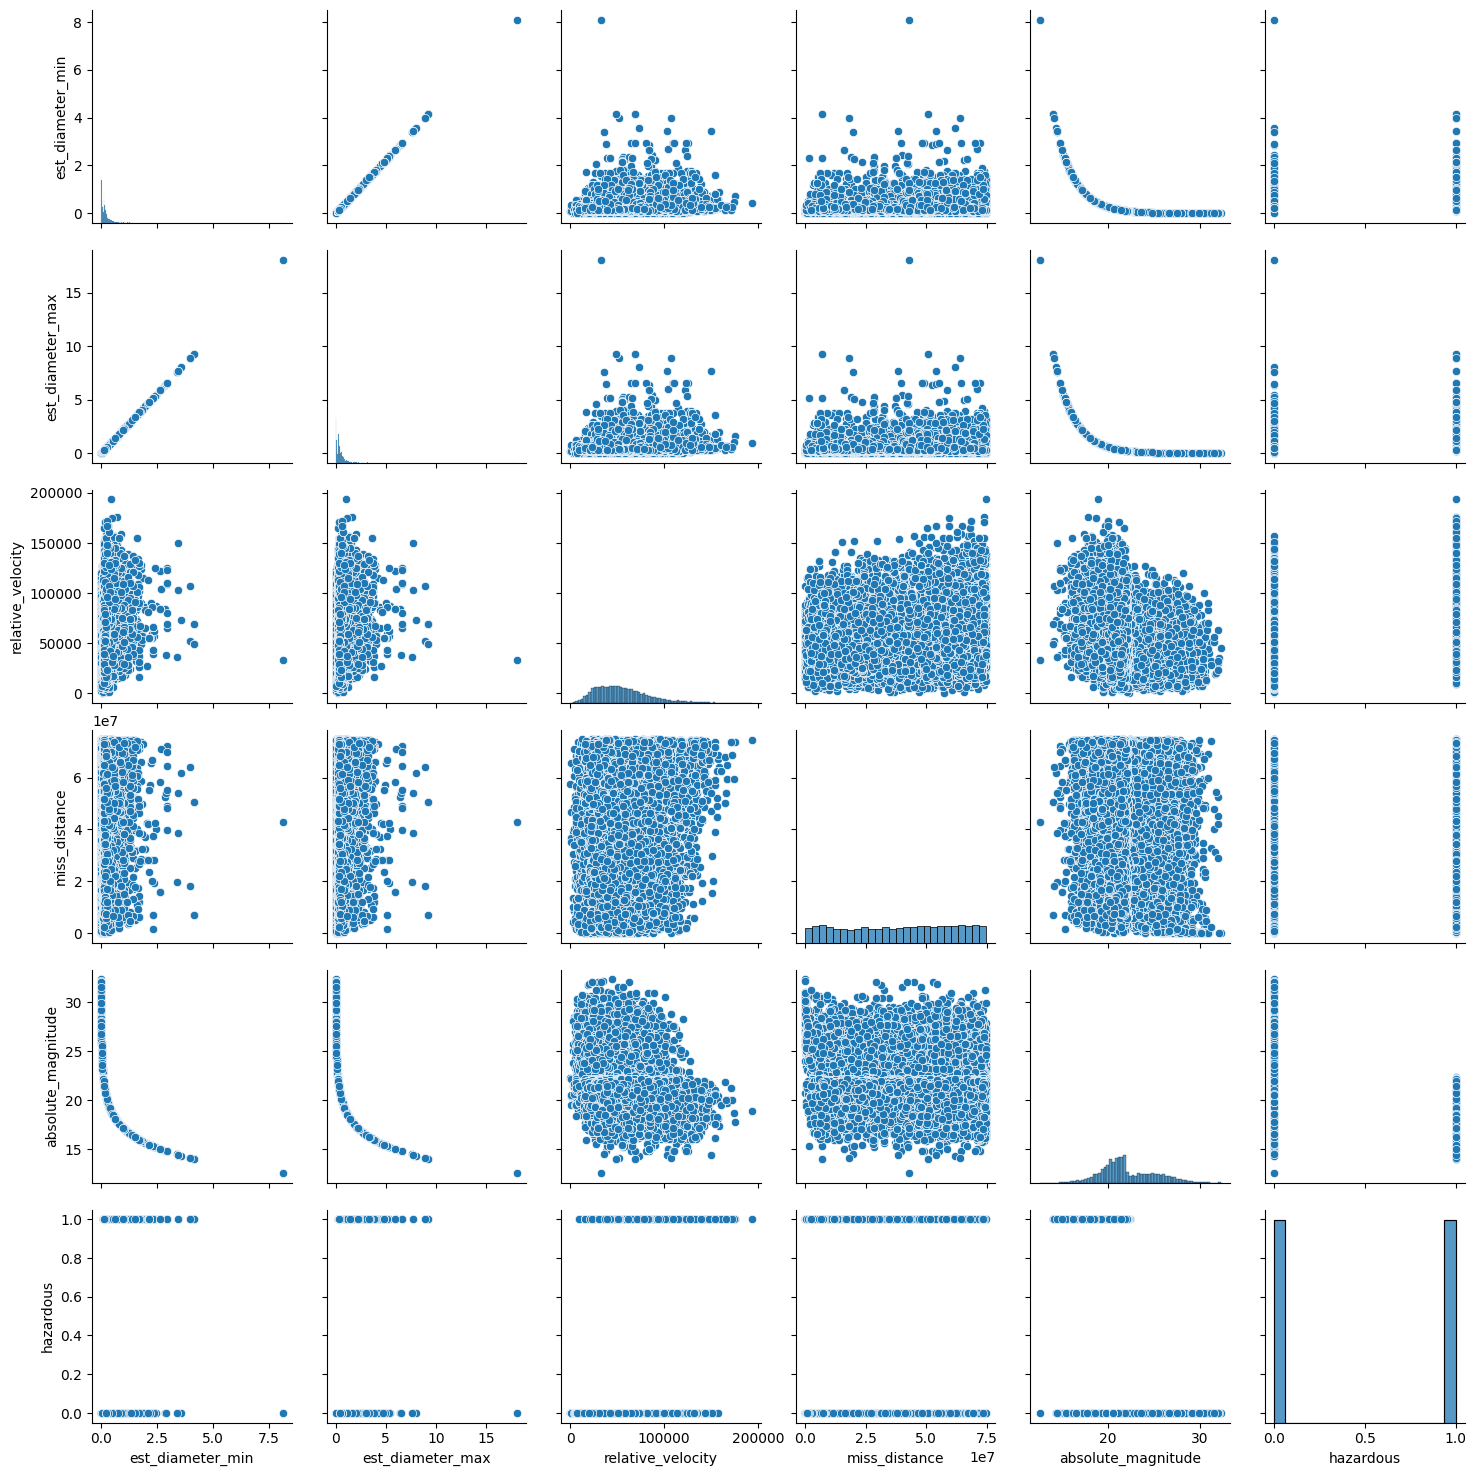

In [62]:
sns.pairplot(new)